In [2]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy



#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()


%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [3]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-mp70iuut
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-mp70iuut


Note: you may need to restart the kernel to use updated packages.


In [4]:
import stella

# Exercise 1

First, we download the relevant data and confirm that we've plotted the correct lightcurve.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

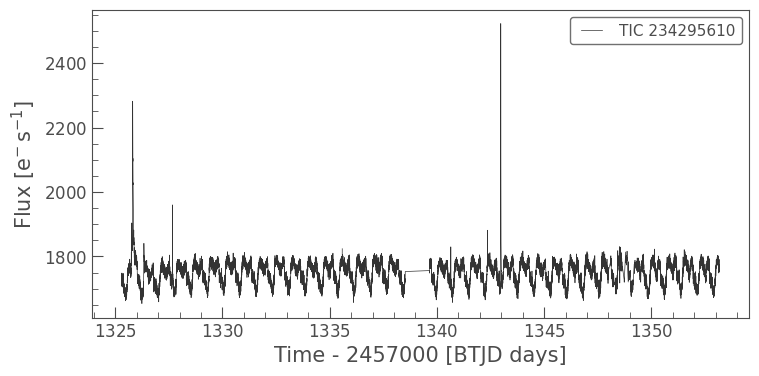

In [6]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()

Now, we'd like to inspect the quality flags for those high-flux time stamps. First, we select those regions. Note that we slice the lightcurve using `flux.values`, because otherwise we wouldn't be able to compare the flux array to the unitless `1900` value.

Because there's a large time separation between these values (that would be joined by a straight line), let's scatter plot the points.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

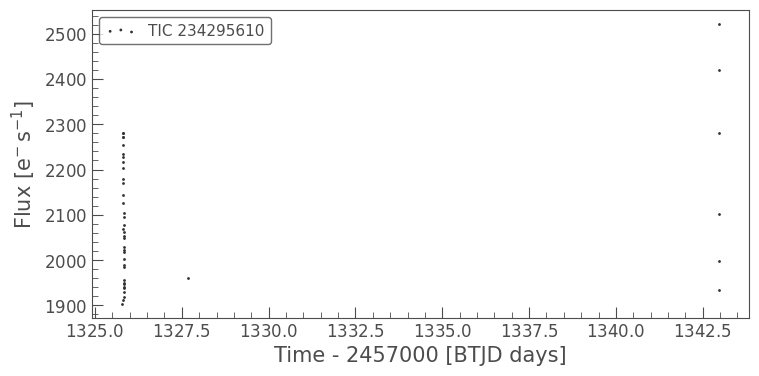

In [7]:
lc_check = lc[lc.flux.value>1900]
lc_check.scatter()

We'll use a code chunk from the [Quality Flags](../../02-quality-flags) notebook below.

In [8]:
quality = lc_check['quality']

bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 

np.any(bad_data)

False

It seems that none of these high-flux timestamps were flagged by the TESS team as being bad-quality. This lends more credence to the idea that there is a real astrophysical source of the high flux — perhaps flares.

# Exercise 2

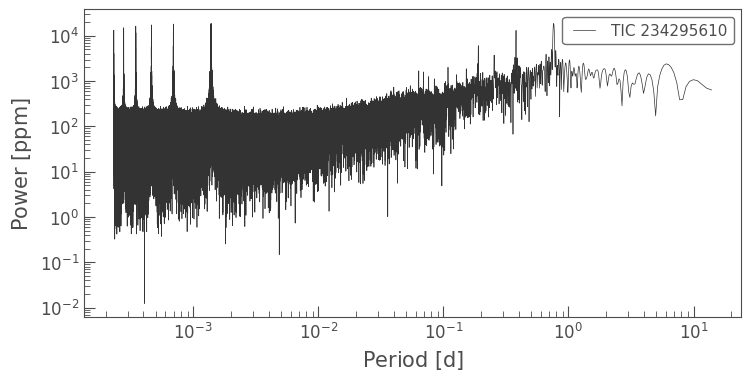

In [9]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

min_period = 1 / 24 / 60 / 60 * 20

pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

pg.plot(scale='log');

We'd like to investigate whether those peaks are harmonics

In [10]:
from scipy.signal import find_peaks

In [11]:
# peaks = find_peaks(pg.power, distance=2000)[0]
peaks = find_peaks(pg.power, height=12500, distance=800)[0]

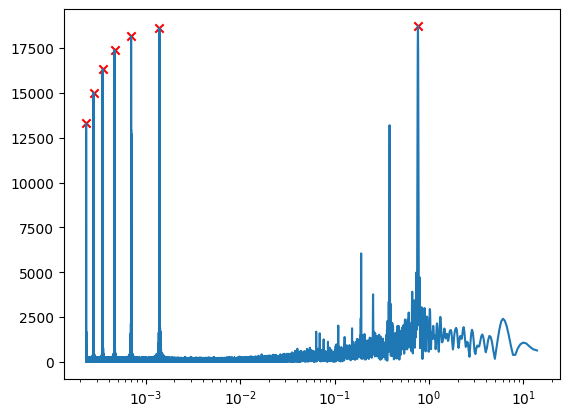

In [12]:
plt.plot(pg.period, pg.power)

plt.scatter(pg.period[peaks], pg.power[peaks], color='red', marker='x')
plt.xscale('log')

In [13]:
pg.period[peaks]

<Quantity [7.61765205e-01, 1.38636373e-03, 6.93813215e-04, 4.62682613e-04,
           3.47064660e-04, 2.77677030e-04, 2.31552268e-04] d>

In [14]:
first_harmonic = pg.period[peaks][1]

In [15]:
per_ratios = []
for per in pg.period[peaks][2:]:
    per_ratios += [first_harmonic/per]

per_ratios = np.array(per_ratios)
        

In [16]:
per_ratios

array([1.99818006, 2.99636013, 3.99454019, 4.99272026, 5.98726045])

Text(0, 0.5, 'Period ratio')

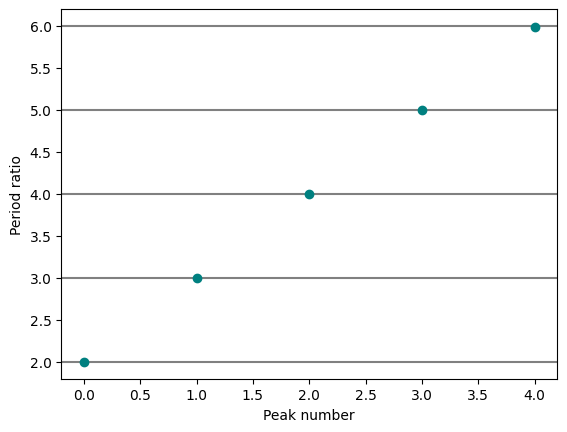

In [17]:
plt.axhline(2, color='gray')
plt.axhline(3, color='gray')
plt.axhline(4, color='gray')
plt.axhline(5, color='gray')
plt.axhline(6, color='gray')
plt.scatter(np.arange(len(per_ratios)), per_ratios, zorder=100, color='teal')

plt.xlabel('Peak number')
plt.ylabel('Period ratio')


The period ratios are close to integer values. Looks like harmonics here!

# Exercise 3

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely. This is, in short, not good. The implication is that when cleaning our datasets, we should take care to not clean them so much that the signal of interest is removed.

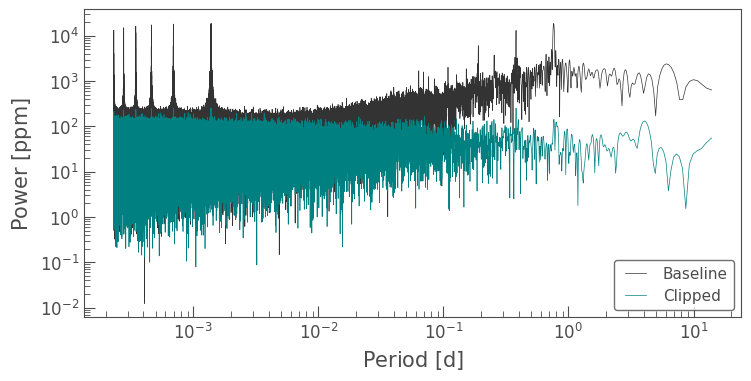

In [18]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

ax = pg.plot(scale='log', label='Baseline')
# pg_clipped.plot(ax=ax, scale='log', zorder=1);
pg_clipped.plot(ax=ax, scale='log', color='teal', label='Clipped');




We can see that in the clippeed lightcurve, the periodogram peaks are still present, but they're only barely visible — and their amplitude is nearly consistent with noise. This feature makes sense when we take a look at the lightcurve that's been clipped. We've removed way too much of the lightcurve!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

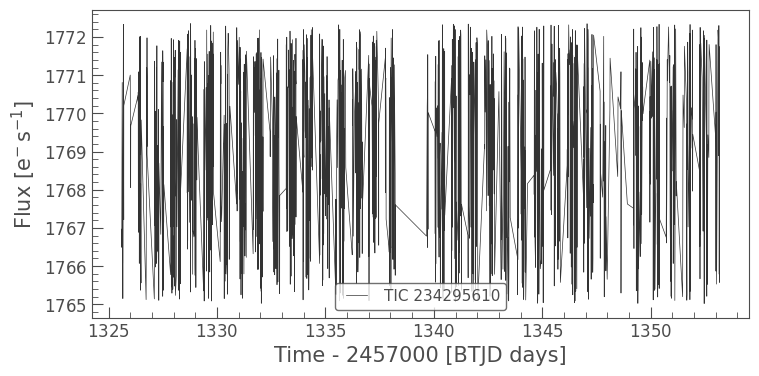

In [19]:
lc_clipped.plot()

# Exercise 4

In [20]:
data_dir = './hellouniverse_stella_500/'
filename = 'Guenther_2020_flare_catalog.txt'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+filename) # using the same catalog as above

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 508.58it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [21]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]


In [22]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5' #AS: ask about where the files are from previous notebooks!
model = keras.models.load_model(cnn_file)

In [23]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

In [24]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


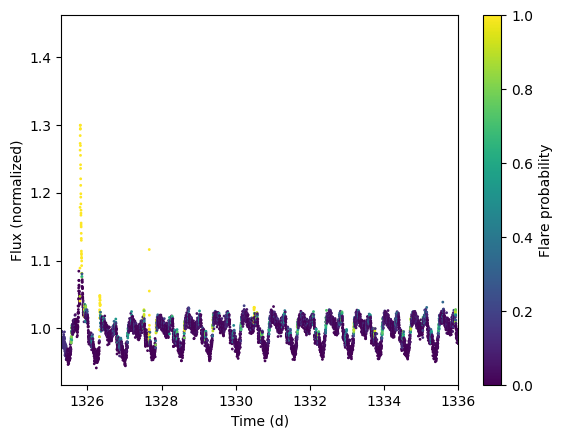

In [25]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux (normalized)')
plt.colorbar(im, label='Flare probability')
plt.xlim(lc.time.min().value, 1336)
plt.show()


Now, we'd like to count the number of distinct flares. Let's count a transition into and out of hgih flare probability (greater than a rating of 0.5 by the classifier) as a flare.

In [26]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])

In [27]:
ff

In [28]:
ff.identify_flare_peaks(threshold=0.5)
ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
234295610.0,1336.5337294934927,1.0164458841762698,15.733979526711776,0.0001,0.01,0.7433666586875916
234295610.0,1336.6670634792652,1.030084465920081,77.18607677976796,0.01,0.01,0.503517746925354
234295610.0,1340.3767937687605,1.0188266236793928,19.615063032310957,0.0001,0.01,0.846248209476471
234295610.0,1341.9031816217816,1.0166045607867409,17.27435594647144,0.0001,0.01,0.5975300669670105
234295610.0,1344.9628970090544,1.0205275288684985,22.32319766900919,0.0001,0.01,0.715408205986023


These tell us a little more here! right now we're just going to count the flare rate in number of flares per day.

In [29]:
def calc_flare_rate(name):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    flare_rate = len(ff.flare_table) / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

Let's recalculate those rotation and flare rates.

In [30]:

G = const.G
M = 1 * u.M_sun
R = 1 * u.R_sun
vc = ((2/3) * G * M / R)**.5

P = 2 * np.pi * R  / vc

min_period = P.to(u.day).value/100

In [31]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
    
    return pg.period_at_max_power


filename = 'Guenther_2020_flare_catalog.txt'

catalog = astropy.io.ascii.read(data_dir + filename)  
stars = catalog['TIC'].data




rot_rates = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate(star_name)
    
    # store result of rotation rate calculation
    rot_rates += [rot_rate]

 27%|██▋       | 12/44 [01:02<01:05,  2.04s/it]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 61%|██████▏   | 27/44 [01:13<00:14,  1.18it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 73%|███████▎  | 32/44 [01:17<00:09,  1.29it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


In [32]:
flare_rates = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


In [33]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

/tmp/ipykernel_209/212443149.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')


Text(0, 0.5, 'Period at max power (d)')

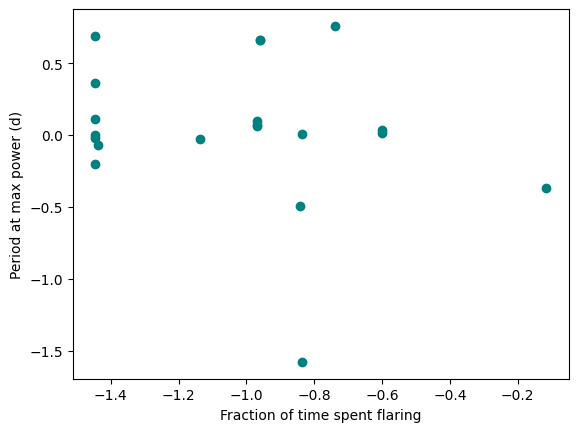

In [34]:
plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

In [35]:
rot_rates, flare_rates = np.array(rot_rates), np.array(flare_rates)

In [36]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

In [37]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

In [38]:
x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

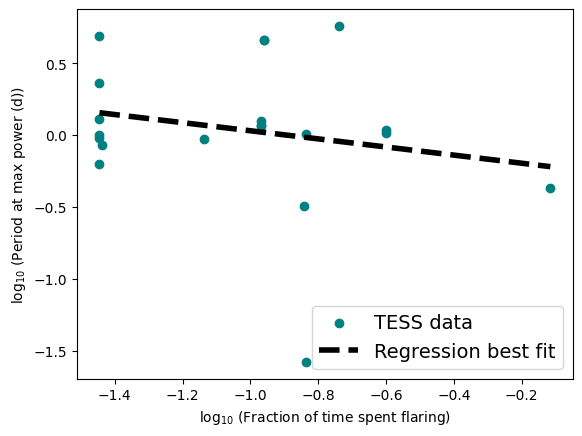

In [39]:
plt.scatter(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')
plt.legend(fontsize=14);

This is not nearly as tight a relationship. The number of flares must be measuring a fundamentally different quantity than the fraction of time spent flaring. Or, if the two metrics do measure the same quantity, this most recent approach must do so in a much more messy way.

# Exercise 5

We can most easily solve this by writing a new function to find rotation periods.

In [40]:
def calc_rotation_rate_stella(name):
     # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    lc = lc.normalize()
    lc = lc.remove_nans()
    mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])
    mProt.run_LS()

    return mProt.LS_results['period_days'].value[0]

In [41]:
rot_rates_constrained = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate_stella(star_name)
    
    # store result of rotation rate calculation
    rot_rates_constrained += [rot_rate]

100%|██████████| 44/44 [00:12<00:00,  3.56it/s]


In [42]:
len(rot_rates_constrained) == len(rot_rates)

True

Looks like we didn't lose any rotation rates by being more precise. How do the plots change?

/tmp/ipykernel_209/1714143192.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')


-0.2824260738079636 -0.2526836958618884


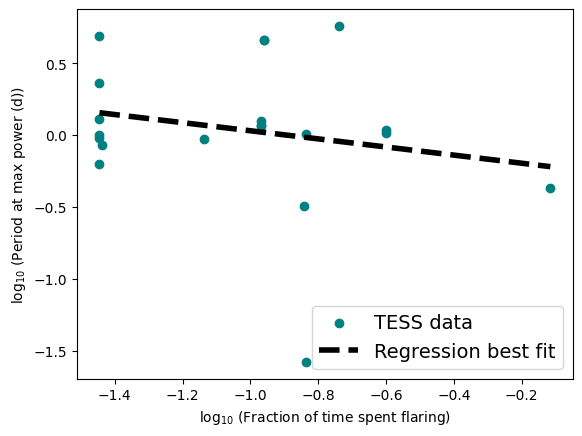

In [43]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')
plt.legend(fontsize=14);

print(slope, intercept)



Looks like we get a slightly steeper relationship this way.

# Exercise 6

Now, let's be more stringent with our flares. We'll use equivalent duration (area underneath the flare) as a proxy for flare duration.

In [44]:
second_to_day_factor = (1 * u.day / (1 * u.second)).si.value

In [45]:
def calc_flare_rate(name):
    """
    todo: add docstring.
    """
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    
    flare_duration_seconds = np.sum(ff.flare_table['ed_s'].value)
    flare_duration_seconds_days = flare_duration_seconds * second_to_day_factor
    flare_rate = flare_duration_seconds_days / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

In [46]:
flare_rates

array([0.        , 0.10946732, 0.        , 0.03586705, 0.        ,
       0.        , 0.14595592, 0.        , 0.        , 0.        ,
       0.10760323, 0.10760116, 0.25107012, 0.03586712, 0.        ,
       0.03586792, 0.07297653, 0.        , 0.14346661, 0.        ,
       0.76625318, 0.        , 0.14595388, 0.        , 0.        ,
       0.03586692, 0.        , 0.        , 0.25106915, 0.03586751,
       0.        , 0.10760205, 0.        , 0.        , 0.        ,
       0.03648907, 0.        , 0.10946634, 0.        , 0.        ,
       0.        , 0.        , 0.18244348, 0.03586796])

In [47]:
flare_rates_durations = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates_durations += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 24.44it/s]


In [48]:
flare_rates_durations

[0.0,
 108740.01343691128,
 0.0,
 29252.779498824162,
 0.0,
 0.0,
 1194959.7854249156,
 0.0,
 0.0,
 0.0,
 101055.42124183405,
 126701.76203768862,
 74294.33964908683,
 48134.097568698606,
 0.0,
 17264.24741817222,
 61213.83752228067,
 0.0,
 1666683.7267428858,
 0.0,
 7890923.28989539,
 0.0,
 261751.00965558251,
 0.0,
 0.0,
 101256.5687663477,
 0.0,
 0.0,
 169363.88477421636,
 10437.141586177333,
 0.0,
 127260.77254492122,
 0.0,
 0.0,
 0.0,
 15033.14688429129,
 0.0,
 95261.60611277254,
 0.0,
 0.0,
 0.0,
 0.0,
 243426.73034144117,
 7318.485193742318]

-0.3494300409805593 1.795846016798184


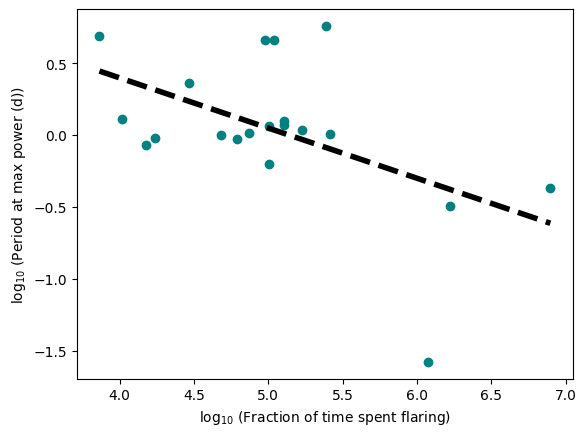

In [49]:
flare_rates_durations = np.array(flare_rates_durations)
rot_rates_cleaned = rot_rates[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_durations_cleaned), np.log10(rot_rates_cleaned))

x = np.linspace(np.min(np.log10(flare_rates_durations_cleaned)), np.max(np.log10(flare_rates_durations_cleaned)), 100)
y = slope * x + intercept

plt.scatter(np.log10(flare_rates_durations_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')

print(slope, intercept)

This looks pretty similar to our trend from the previous plot — maybe even a bit tighter. We'll test the significance of things in the next exercise.